In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

!pip install yfinance
import yfinance as yf
import datetime

In [74]:
today = datetime.date.today()
STOCK = 'AAPL'
data = yf.download(STOCK, start = '2012-01-01', end=today)
data = data.filter(['Close'])

[*********************100%***********************]  1 of 1 completed


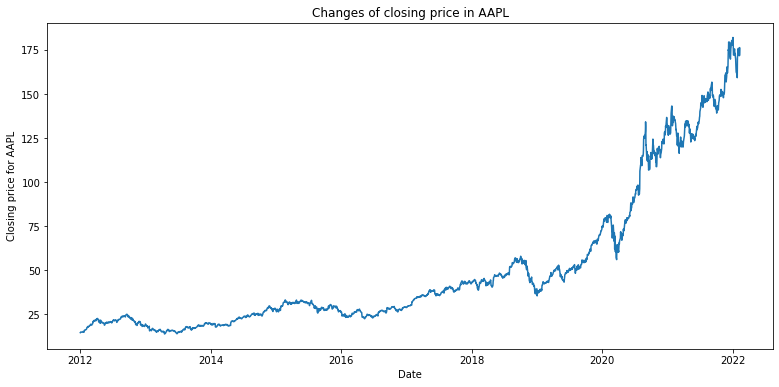

In [75]:
plt.figure(figsize=(13,6))

plt.title(f'Changes of closing price in {STOCK}')
plt.xlabel('Date')
plt.ylabel(f'Closing price for {STOCK}')

plt.plot(data)
plt.show()

In [76]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

In [77]:
train_len = int((len(scaled_data)-60) * .8)
X_train = np.array( [scaled_data[i:(i+60)] for i in range(train_len)] )
y_train = np.array( [scaled_data[i+60] for i in range(train_len)] )

In [78]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1) )
X_train.shape

(1988, 60, 1)

In [79]:
model = Sequential(
    [
     LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
     LSTM(50, return_sequences=False),
     Dense(25),
     Dense(1) 
    ]
)

In [80]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [81]:
model.fit(X_train, y_train, batch_size=1, epochs=10)

Epoch 1/10
1988/1988 [==============================] - 57s 27ms/step - loss: 1.8726e-04
Epoch 2/10
1988/1988 [==============================] - 53s 27ms/step - loss: 1.0581e-04
Epoch 3/10
1988/1988 [==============================] - 53s 27ms/step - loss: 7.9916e-05
Epoch 4/10
1988/1988 [==============================] - 53s 27ms/step - loss: 5.3926e-05
Epoch 5/10
1988/1988 [==============================] - 53s 27ms/step - loss: 6.0157e-05
Epoch 6/10
1988/1988 [==============================] - 54s 27ms/step - loss: 4.8990e-05
Epoch 7/10
1988/1988 [==============================] - 54s 27ms/step - loss: 4.2273e-05
Epoch 8/10
1988/1988 [==============================] - 53s 27ms/step - loss: 4.2696e-05
Epoch 9/10
1988/1988 [==============================] - 53s 27ms/step - loss: 3.9682e-05
Epoch 10/10
1988/1988 [==============================] - 54s 27ms/step - loss: 3.5614e-05


In [82]:
X_test = np.array( [scaled_data[i-60:i] for i in range(train_len, len(scaled_data))] )
y_test = np.array( [scaled_data[i] for i in range(train_len, len(scaled_data))] )

In [83]:
shape = X_test.shape
X_test = np.reshape(X_test, (shape[0], shape[1], 1))

In [84]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

In [85]:
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

120.3588257579417

In [86]:
train = data[:train_len]
valid = pd.DataFrame()
valid['Close'] = data[train_len:]
valid['Predictions'] = predictions
last_valid_days = valid.tail(60)

In [87]:
last_60_days = np.array(data[-60:])
last_60_days_scaled = np.array([ scaler.fit_transform(last_60_days) ])
next_days_scaled, next_days_prediction = [], []
x_days = 20

for i in range(x_days):
    next_day_prediction = model.predict(last_60_days_scaled)
    next_days_scaled.append( next_day_prediction )
    last_60_days_scaled = np.append( last_60_days_scaled[0][1:], np.array([[[next_days_scaled[-1]]]]) )
    last_60_days_scaled = np.reshape( last_60_days_scaled, (1, 60, 1) )
    
for x in next_days_scaled:
    next_days_prediction.append( scaler.inverse_transform(x) )

next_days_df = pd.DataFrame()
next_days_df['Date'] = np.array( [today + datetime.timedelta(days=i) for i in range(0, x_days)] )
next_days_df['Predictions'] = np.reshape(np.array(next_days_prediction), (x_days))

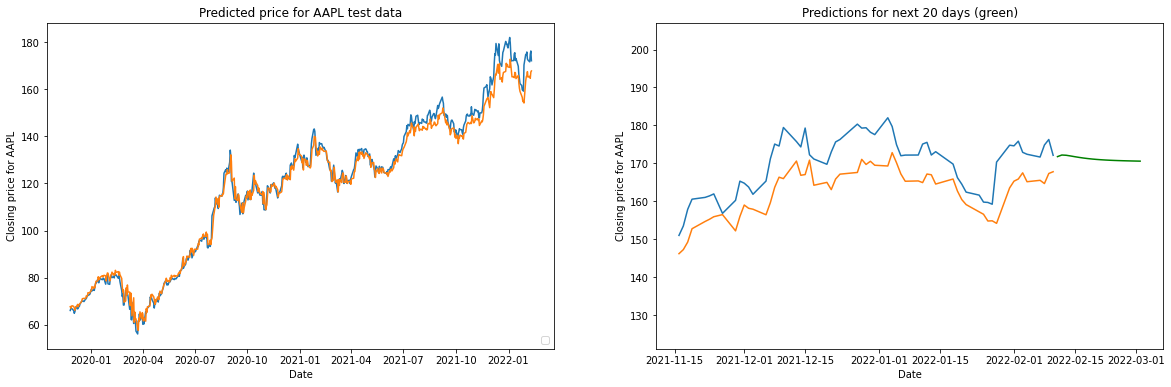

<Figure size 1440x504 with 0 Axes>

In [88]:
plt.figure(figsize=(20,6))
plt1 = plt.subplot(121)
plt1.set_title(f'Predicted price for {STOCK} test data')
plt1.set_xlabel('Date')
plt1.set_ylabel(f'Closing price for {STOCK}')
plt1.legend(['Close price', 'Predicted price'], loc='lower right')
plt1.plot(valid[['Close', 'Predictions']])


plt2 = plt.subplot(122)
plt2.margins(0.05, .7)
plt2.set_title(f'Predictions for next {x_days} days (green)')
plt2.set_xlabel('Date')
plt2.set_ylabel(f'Closing price for {STOCK}')
plt2.plot(last_valid_days)
plt2.plot(next_days_df['Date'], next_days_df['Predictions'], color='green')

plt.figure(figsize=(20,7))
plt.show()